<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session8/Session8_GN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is all about having a potent classifier for Cifar-10 dataset with the following considerations:
* Make this network: C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 cN is 1x1 Layer
* Keep the parameter count less than 50000
* Max Epochs is 20
* Use of Group Normalization with DP

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# !pip install portalocker
# !pip install torchview
# !pip install torcheval
# !pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00


## Helpers and Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [8]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [10]:
# downloading train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 13169709.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [13]:
# #Dataloaders
# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [14]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [15]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

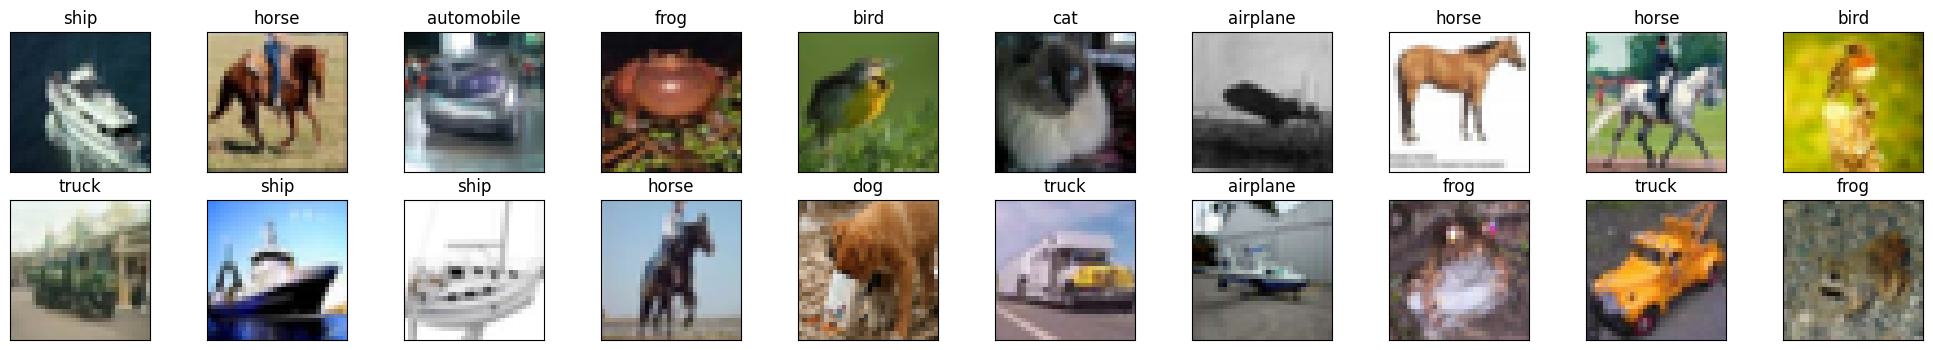

In [16]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building and optimization

In [17]:
class Cifar_Baseline_DP(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
         nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
         nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.GroupNorm(4,multiplier*hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.GroupNorm(4,hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [18]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [19]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [20]:
# New Model Instance
baseline_model_1 = Cifar_Baseline_DP(in_channels=3, hidden_units=16, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         GroupNorm-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
         GroupNorm-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             528
        GroupNorm-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
        MaxPool2d-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 32, 12, 12]           4,640
        GroupNorm-14           [-1, 32,

In [21]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [22]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 1.8416633456564315 Avg Train Metric: 0.23419327759529318: 100%|██████████| 391/391 [00:25<00:00, 15.21it/s]


Function Took 25.7301 seconds


Avg Test Loss: 1.7767597346366206 Avg Test Metric: 0.3774383388742616: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s]


Function Took 3.2176 seconds
Validation loss decreased (inf --> 1.776760).  Saving model ...
Epoch 1


Avg Train Loss: 1.4983266009699048 Avg Train Metric: 0.4332573347536804: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]


Function Took 20.6945 seconds


Avg Test Loss: 1.3992390579815153 Avg Test Metric: 0.4979978135869473: 100%|██████████| 79/79 [00:02<00:00, 26.89it/s]


Function Took 2.9442 seconds
Validation loss decreased (1.776760 --> 1.399239).  Saving model ...
Epoch 2


Avg Train Loss: 1.365236625646996 Avg Train Metric: 0.49581920841465826: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]


Function Took 20.6792 seconds


Avg Test Loss: 1.2345172740236114 Avg Test Metric: 0.5612683960154087: 100%|██████████| 79/79 [00:02<00:00, 26.42it/s]


Function Took 2.9991 seconds
Validation loss decreased (1.399239 --> 1.234517).  Saving model ...
Epoch 3


Avg Train Loss: 1.2447569992231287 Avg Train Metric: 0.5489188373241278: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]


Function Took 20.8957 seconds


Avg Test Loss: 1.2008565030520475 Avg Test Metric: 0.567139173610301: 100%|██████████| 79/79 [00:02<00:00, 27.52it/s]


Function Took 2.8772 seconds
Validation loss decreased (1.234517 --> 1.200857).  Saving model ...
Epoch 4


Avg Train Loss: 1.1767586823314657 Avg Train Metric: 0.577737941766334: 100%|██████████| 391/391 [00:19<00:00, 19.62it/s]


Function Took 19.9371 seconds


Avg Test Loss: 1.1220926732956609 Avg Test Metric: 0.5970336545871783: 100%|██████████| 79/79 [00:03<00:00, 20.74it/s]


Function Took 3.8195 seconds
Validation loss decreased (1.200857 --> 1.122093).  Saving model ...
Epoch 5


Avg Train Loss: 1.1124088547723678 Avg Train Metric: 0.5952940714328795: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]


Function Took 19.4932 seconds


Avg Test Loss: 1.0696699226958841 Avg Test Metric: 0.6254196959205821: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


Function Took 3.5117 seconds
Validation loss decreased (1.122093 --> 1.069670).  Saving model ...
Epoch 6


Avg Train Loss: 1.0762644102201437 Avg Train Metric: 0.6166069763700676: 100%|██████████| 391/391 [00:20<00:00, 19.46it/s]


Function Took 20.0960 seconds


Avg Test Loss: 1.0480180978775024 Avg Test Metric: 0.6280504963066005: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


Function Took 2.8669 seconds
Validation loss decreased (1.069670 --> 1.048018).  Saving model ...
Epoch 7


Avg Train Loss: 1.0333142102222004 Avg Train Metric: 0.6368881390832574: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]


Function Took 20.8405 seconds


Avg Test Loss: 1.0024937044216107 Avg Test Metric: 0.6528452348105515: 100%|██████████| 79/79 [00:02<00:00, 27.01it/s]


Function Took 2.9333 seconds
Validation loss decreased (1.048018 --> 1.002494).  Saving model ...
Epoch 8


Avg Train Loss: 0.9995415402800226 Avg Train Metric: 0.6529104031260361: 100%|██████████| 391/391 [00:21<00:00, 18.60it/s]


Function Took 21.0285 seconds


Avg Test Loss: 0.9425740928589543 Avg Test Metric: 0.672133246554604: 100%|██████████| 79/79 [00:02<00:00, 26.38it/s]


Function Took 3.0017 seconds
Validation loss decreased (1.002494 --> 0.942574).  Saving model ...
Epoch 9


Avg Train Loss: 0.9736755029929568 Avg Train Metric: 0.6591854647297384: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]


Function Took 19.9472 seconds


Avg Test Loss: 0.948857238021078 Avg Test Metric: 0.678665552712694: 100%|██████████| 79/79 [00:03<00:00, 23.42it/s]


Function Took 3.3832 seconds
EarlyStopping counter: 1 out of 3
Epoch 10


Avg Train Loss: 0.9480085786041397 Avg Train Metric: 0.6676237881945832: 100%|██████████| 391/391 [00:20<00:00, 19.14it/s]


Function Took 20.4379 seconds


Avg Test Loss: 0.8940440703041946 Avg Test Metric: 0.691746889035913: 100%|██████████| 79/79 [00:04<00:00, 19.50it/s]


Function Took 4.0592 seconds
Validation loss decreased (0.942574 --> 0.894044).  Saving model ...
Epoch 11


Avg Train Loss: 0.9212145226081009 Avg Train Metric: 0.6735758589356756: 100%|██████████| 391/391 [00:19<00:00, 19.64it/s]


Function Took 19.9158 seconds


Avg Test Loss: 0.9332602612579926 Avg Test Metric: 0.6739325395113305: 100%|██████████| 79/79 [00:03<00:00, 24.65it/s]


Function Took 3.2149 seconds
EarlyStopping counter: 1 out of 3
Epoch 12


Avg Train Loss: 0.9128943927147809 Avg Train Metric: 0.6773008658453021: 100%|██████████| 391/391 [00:20<00:00, 19.11it/s]


Function Took 20.4687 seconds


Avg Test Loss: 0.9081932992874822 Avg Test Metric: 0.6842429079586947: 100%|██████████| 79/79 [00:02<00:00, 26.50it/s]


Function Took 2.9882 seconds
EarlyStopping counter: 2 out of 3
Epoch 13


Avg Train Loss: 0.8913894958813172 Avg Train Metric: 0.6877391972505223: 100%|██████████| 391/391 [00:20<00:00, 18.97it/s]


Function Took 20.6150 seconds


Avg Test Loss: 0.8467704766913305 Avg Test Metric: 0.7133398025850707: 100%|██████████| 79/79 [00:03<00:00, 26.16it/s]


Function Took 3.0295 seconds
Validation loss decreased (0.894044 --> 0.846770).  Saving model ...
Epoch 14


Avg Train Loss: 0.871489160810895 Avg Train Metric: 0.6966042142085103: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s]


Function Took 21.2163 seconds


Avg Test Loss: 0.8740160925478875 Avg Test Metric: 0.6922281625904615: 100%|██████████| 79/79 [00:03<00:00, 26.10it/s]


Function Took 3.0360 seconds
EarlyStopping counter: 1 out of 3
Epoch 15


Avg Train Loss: 0.8611517970824181 Avg Train Metric: 0.6960267253848903: 100%|██████████| 391/391 [00:20<00:00, 19.20it/s]


Function Took 20.3778 seconds


Avg Test Loss: 0.8525626523585259 Avg Test Metric: 0.7066076752505724: 100%|██████████| 79/79 [00:03<00:00, 22.22it/s]


Function Took 3.5662 seconds
EarlyStopping counter: 2 out of 3
Epoch 16


Avg Train Loss: 0.8397845726488801 Avg Train Metric: 0.7069702386246313: 100%|██████████| 391/391 [00:20<00:00, 19.52it/s]


Function Took 20.0398 seconds


Avg Test Loss: 0.842347680013391 Avg Test Metric: 0.7071703272529796: 100%|██████████| 79/79 [00:03<00:00, 19.76it/s]


Function Took 4.0035 seconds
Validation loss decreased (0.846770 --> 0.842348).  Saving model ...
Epoch 17


Avg Train Loss: 0.8205867632270774 Avg Train Metric: 0.7169804188906385: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Function Took 19.8148 seconds


Avg Test Loss: 0.8288665632658367 Avg Test Metric: 0.7203041352803194: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s]


Function Took 3.0640 seconds
Validation loss decreased (0.842348 --> 0.828867).  Saving model ...
Epoch 18


Avg Train Loss: 0.8148451688344521 Avg Train Metric: 0.7181919552481083: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]


Function Took 20.8454 seconds


Avg Test Loss: 0.8040872095506403 Avg Test Metric: 0.7169453252719927: 100%|██████████| 79/79 [00:03<00:00, 26.32it/s]


Function Took 3.0073 seconds
Validation loss decreased (0.828867 --> 0.804087).  Saving model ...
Epoch 19


Avg Train Loss: 0.8043948436332176 Avg Train Metric: 0.7205343743419403: 100%|██████████| 391/391 [00:21<00:00, 18.52it/s]


Function Took 21.1189 seconds


Avg Test Loss: 0.8182322692267502 Avg Test Metric: 0.7208978563924379: 100%|██████████| 79/79 [00:02<00:00, 27.01it/s]

Function Took 2.9369 seconds
EarlyStopping counter: 1 out of 3


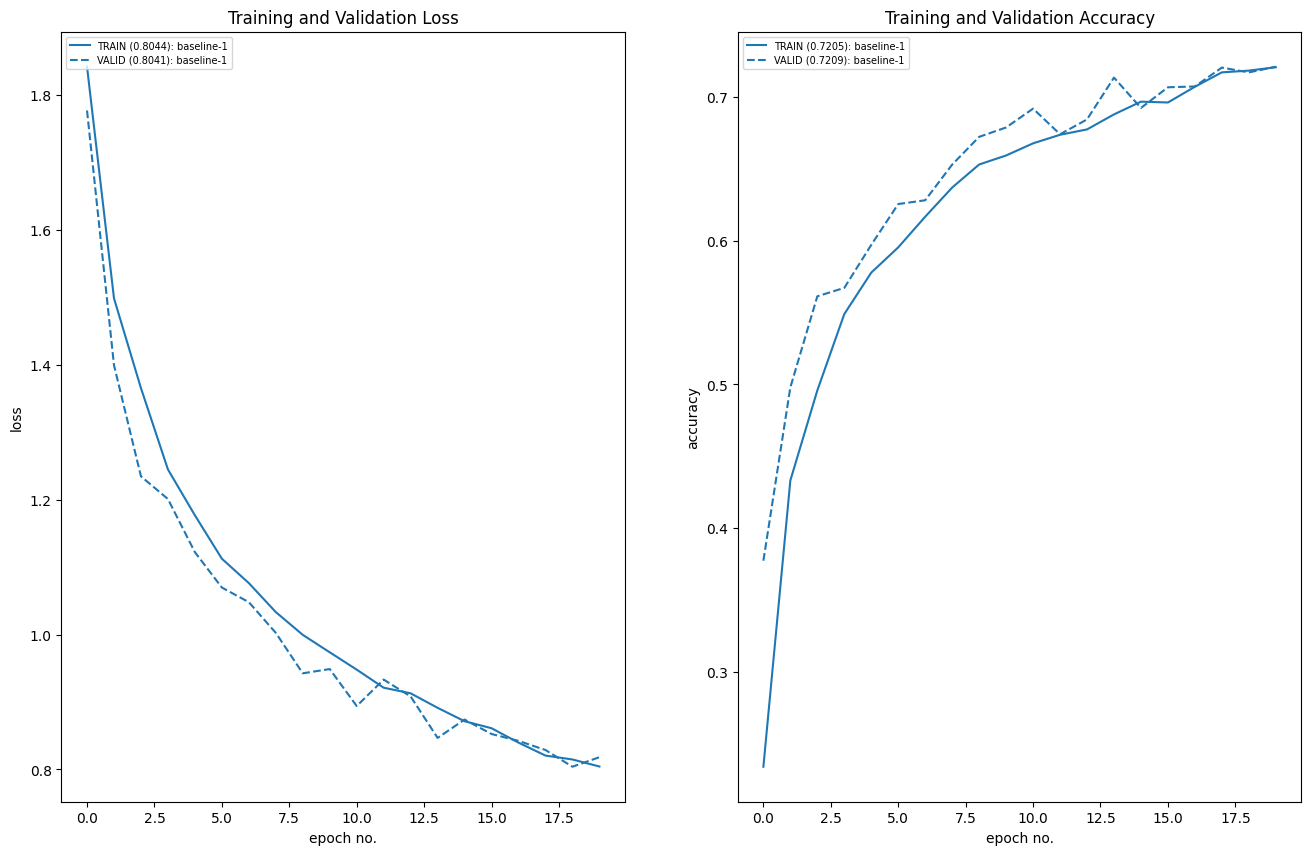

In [24]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

## Eval Framework and Metrics

In [25]:
def eval_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                ):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  predictions = []
  actuals = []

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      actuals.append(label)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      # metric calc
      preds = torch.argmax(preds,dim=1)

      predictions.append(preds)

  return torch.cat(actuals, dim=0).cpu().numpy(), torch.cat(predictions, dim=0).cpu().numpy()

In [26]:
eval_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
actuals , predictions = eval_module(baseline_model_1, device, eval_loader)

100%|██████████| 79/79 [00:04<00:00, 17.43it/s]


In [27]:
min(actuals),max(actuals)

(0, 9)

## Metrics

In [28]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.70      0.78      0.74      1000
  automobile       0.83      0.90      0.87      1000
        bird       0.60      0.64      0.62      1000
         cat       0.53      0.48      0.50      1000
        deer       0.82      0.54      0.65      1000
         dog       0.59      0.68      0.63      1000
        frog       0.84      0.74      0.79      1000
       horse       0.73      0.79      0.76      1000
        ship       0.83      0.85      0.84      1000
       truck       0.83      0.84      0.84      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



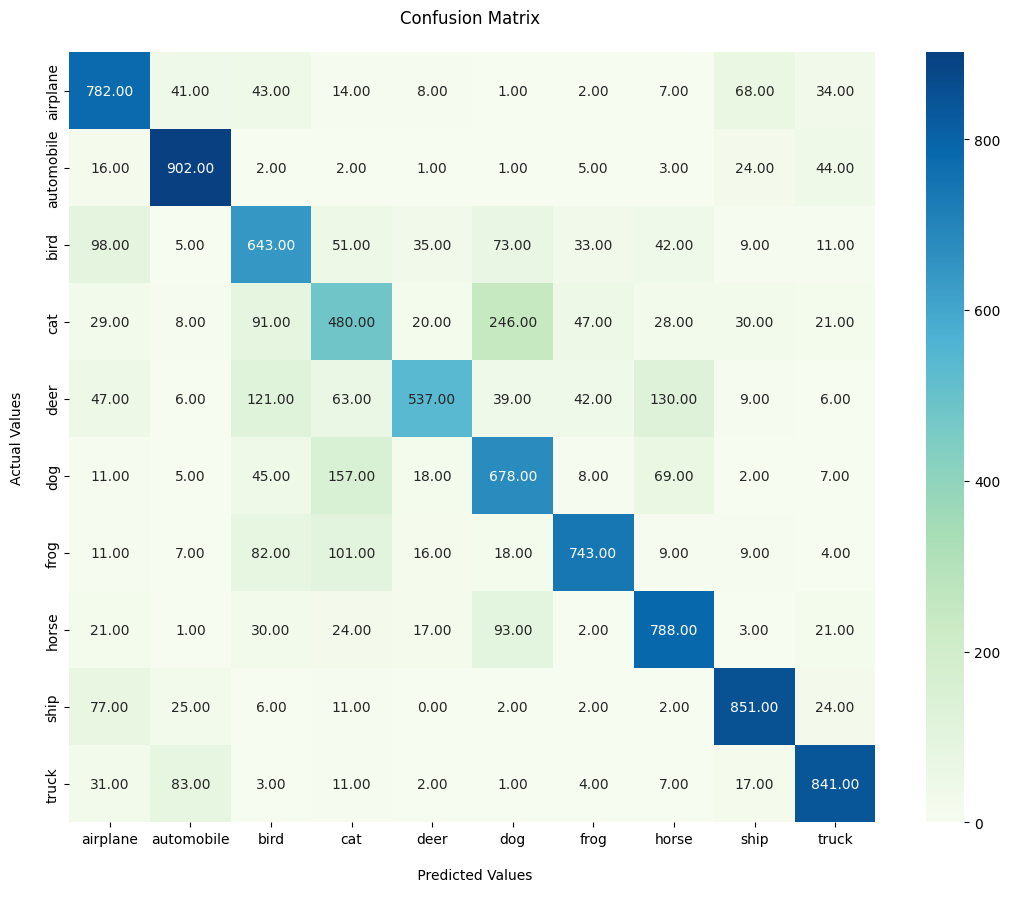

In [29]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [30]:
mismatches = np.where(predictions != actuals)

In [31]:
# idx = mismatches[0][0]
# print(f'Actual: {classes[actuals[idx]]}')
# print(f'Predicted: {classes[predictions[idx]]}')

Label: airplane and Prediction: cat


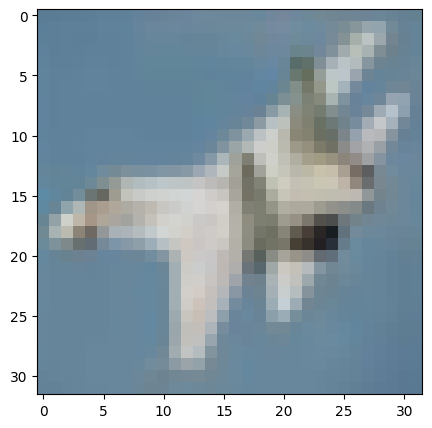

Label: horse and Prediction: dog


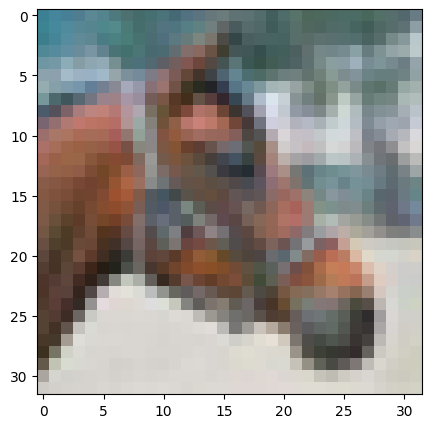

Label: dog and Prediction: bird


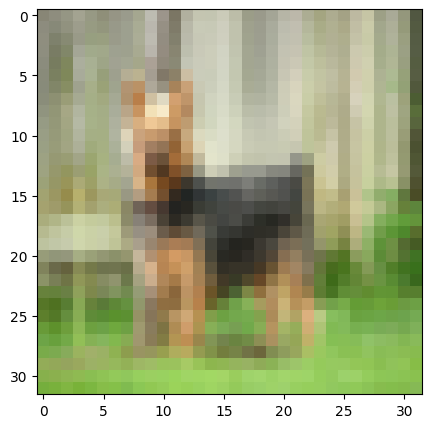

Label: deer and Prediction: ship


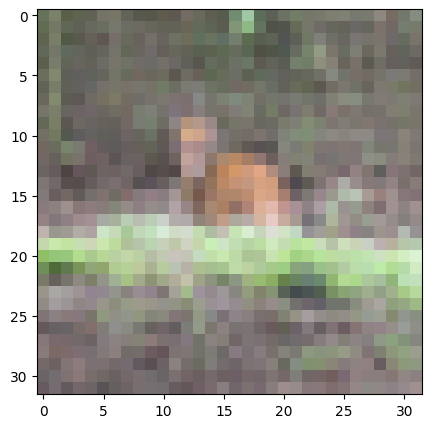

Label: dog and Prediction: cat


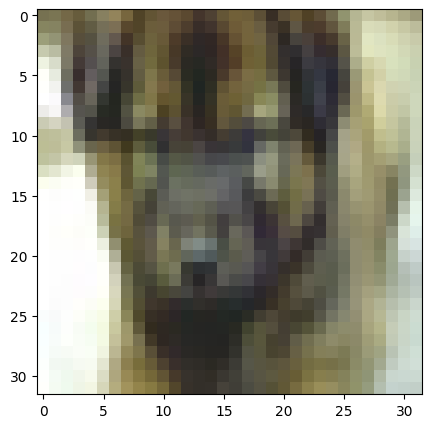

Label: bird and Prediction: ship


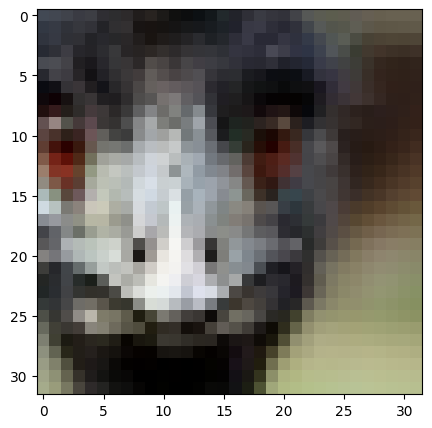

Label: deer and Prediction: horse


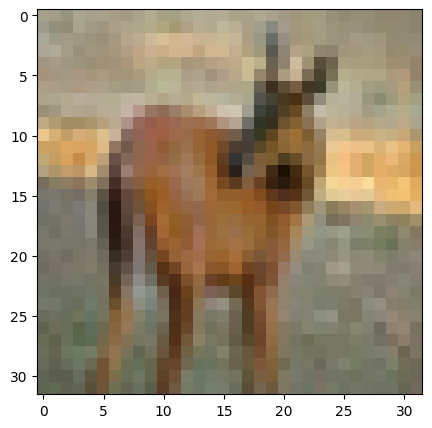

Label: deer and Prediction: airplane


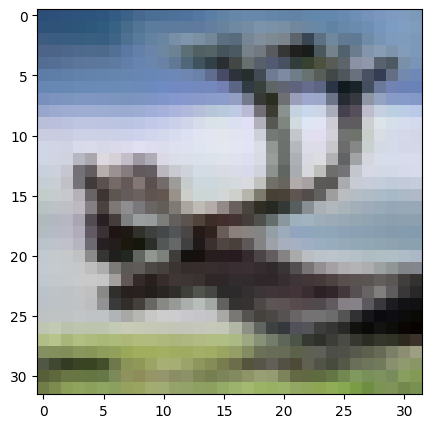

Label: frog and Prediction: bird


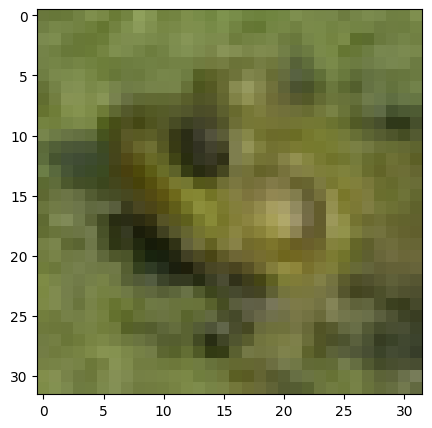

Label: airplane and Prediction: horse


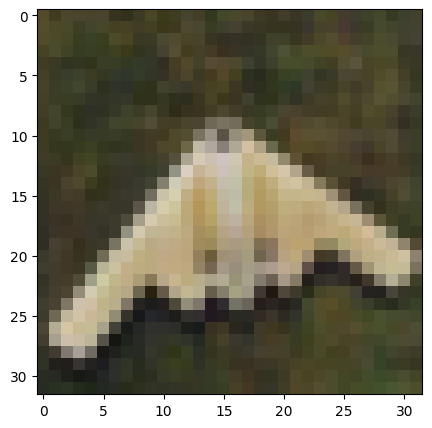

In [32]:
for idx in mismatches[0][:10]:
  plt.figure(figsize=(5,5))
  img, label = test[idx]
  imshow(img)
  print(f'Label: {classes[label]} and Prediction: {classes[predictions[idx]]}')
  plt.show()

Sumamry:

- The model used is a Cifar_Baseline, which is a convolutional neural network with three convolution blocks, each followed by a transition block.
- The model achieved a training accuracy of 70% and a validation accuracy of 70%.
- The model's training loss was 0.84 and its validation loss was 0.83.
- The model's confusion matrix showed that it was most accurate at classifying Autombile and least accurate at classifying Cats.
- Early stopping was triggered after N epochs due to lack of improvement in validation loss.
- Addition of Dropouts makes a significant difference in terms of overfitting.

## Links:
https://medium.com/@zljdanceholic/groupnorm-then-batchnorm-instancenorm-layernorm-e2b2a1d350a0
https://wandb.ai/wandb_fc/Normalization/reports/Normalization-Series-What-is-Batch-Norm---VmlldzoxMjk2ODcz
https://wandb.ai/wandb_fc/GroupNorm/reports/Group-Normalization-in-Pytorch-With-Examples---VmlldzoxMzU0MzMy
https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
https://wandb.ai/wandb_fc/Normalization-Series/reports/Instance-Normalization-in-PyTorch-With-Examples---VmlldzoxNDIyNTQx